# Imports for Simulation and Visualiation

In [2]:
from random import randint, shuffle
import time
import matplotlib.pyplot as plt
import numpy as np

### Class Game
- Attributes
    - PayoffMatrix
        : Payoff Matrix of two player Game
- Methods
    - findSDSE
        : Computes Strong Dominant Strategy Equilibrium if it exists.
    - findMSNE
        : Computes MSNE using indifference priciple.

In [3]:
class game:
    def __init__(self):
        food = (MAX_FOOD_PER_ROUND + MIN_FOOD_PER_ROUND)//2
        self.payoffMatrix = [ 
                            [[(food//2) - ENERGY_LOSS_FROM_FIGHTING, (food//2) - ENERGY_LOSS_FROM_FIGHTING],[food,0]],
                            [[0, food],[(food//2), (food//2)]]
                            ]
#     Arguments : None, Return: list of SDSE strategy
    def findSDSE(self):
        P1 = []
        P2 = []
        if self.payoffMatrix[0][0][0] > self.payoffMatrix[1][0][0] and self.payoffMatrix[0][1][0] > self.payoffMatrix[1][1][0]:
            P1.append(0)
        if self.payoffMatrix[0][0][0] < self.payoffMatrix[1][0][0] and self.payoffMatrix[0][1][0] < self.payoffMatrix[1][1][0]:
            P1.appendp(1)
        if self.payoffMatrix[0][0][1] > self.payoffMatrix[0][1][1] and self.payoffMatrix[1][0][1] > self.payoffMatrix[1][1][1]:
            P2.append(0)
        if self.payoffMatrix[0][0][1] < self.payoffMatrix[0][1][1] and self.payoffMatrix[1][0][1] < self.payoffMatrix[1][1][1]:
            P2.append(1)
        ret = [(x, y) for x in P1 for y in P2]
        return ret

#   Arguments: None, Return list of probability distribution over strategy for player 1 and player 2
    def findMSNE(self):

        SDSE = self.findSDSE()
        p = np.zeros(2)
        q = np.zeros(2)
        if(len(SDSE) > 0):
            p[SDSE[0][0]] = 1
            q[SDSE[0][1]] = 1
            return [p,q]
        
#         row player Indifference Condition
        a = np.array([[1, 1], [self.payoffMatrix[0][0][0] - self.payoffMatrix[1][0][0], self.payoffMatrix[0][1][0] - self.payoffMatrix[1][1][0]] ])
        b = np.array([1, 0])
        q = np.linalg.solve(a, b)
        
#         col player Indifference Condition
        a = np.array([[1, 1], [self.payoffMatrix[0][0][1] - self.payoffMatrix[0][1][1], self.payoffMatrix[1][0][1] - self.payoffMatrix[1][1][1]] ])
        b = np.array([1, 0])
        p = np.linalg.solve(a, b) 
        return [p,q]
        

#### Global intitial Condtion
1. STARTING_DOVES
    : The number of players who are Doves in the beginning
2. STARTING_HAWKS
    : The number of players who are Doves in the beginning
3. ROUNDS
    : Number of Rounds in the simulation
4. STARTING_ENERGY
    : The amount of energy with which each player starts the game.
5. MIN_FOOD_PER_ROUND
    : Min energy available per food.
6. MAX_FOOD_PER_ROUND
    : Max energy available per food.
7. MAX_FOOD_APPEARANCE
    : Max number of food appearance per round
8. ENERGY_REQUIRED_FOR_REPRODUCTION
    : Minimum energy required to reproduce
9. ENERGY_LOSS_PER_ROUND
    : Energy spent for surviving a round
10. ENERGY_LOSS_FROM_FIGHTING
    : Energy spent over fighting
11. ENERGY_REQUIRED_FOR_LIVING
    : Minimum energy required to remain alive
    
#### Model Formulation

1. Game Starts with gameInit(), a function which initialize all the agents. These agents are the players in this game and they can be either HAWK or DOVE. 
2. Then rounds start, while rounds <= ROUNDS **and** Agents Remaining >=2:
    1. Call AwakenAgents(), set the state of agent to **Awake State**.
    2. Generate the random food for the current round.
    3. Shuffle the agents for random pairing.
    4. Then pair the agents and let them compete over the food, However the max number of food appearance is limited by MAX_FOOD_APPEARANCE.
    5. Then the agents pay the cost of living a round.
    6. Cull() is called and every agent with energy less than ENERGY_REQUIRED_FOR_LIVING is deleted from the simulation.
    7. The remaing of the agents then reproduce if they have energy greater than ENERGY_REQUIRED_FOR_REPRODUCTION.
    8. Data is collected stored for further analysis.
3. After the simulation ends we analyze and compare the data collected with the  theoretically calculated MSNE.
    

In [114]:
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 200
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 60
MAX_FOOD_PER_ROUND = 60
MAX_FOOD_APPEARANCE = 1000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 20+20+20+20
ENERGY_REQUIRED_FOR_LIVING = 10

STATUS_ACTIVE = "active"
STATUS_ASLEEP = "asleep"

TYPE_HAWK = "hawk"
TYPE_DOVE = "dove"

agents = []

# Graph stuff
graph_hawk_points = []
graph_dove_points = []

AGENT_ID = 1
class Agent:
    
    def __init__(self, agent_type, status, energy):
        global AGENT_ID
        self.id = AGENT_ID
        AGENT_ID += 1
        self.agent_type = agent_type
        self.status = status
        self.energy = energy
    def wake(self):
        self.status = STATUS_ACTIVE
    def sleep(self):
        self.status = STATUS_ASLEEP

def gameInit():
    global agents
    agents = []
    for x in range(0,STARTING_DOVES):
        a = Agent(TYPE_DOVE, STATUS_ASLEEP, STARTING_ENERGY)
        agents.append(a)
    for x in range(0,STARTING_HAWKS):
        a = Agent(TYPE_HAWK, STATUS_ASLEEP, STARTING_ENERGY)
        agents.append(a)

def compete(agent, nemesis, food):
# add a food fuction inside agent
    if agent.agent_type == TYPE_HAWK and nemesis.agent_type == TYPE_HAWK:
        # food distributed as food // 2 and loss from fighting subtracted
        agent.energy += (food//2)
        agent.energy -= ENERGY_LOSS_FROM_FIGHTING
        nemesis.energy += (food//2)
        nemesis.energy -= ENERGY_LOSS_FROM_FIGHTING
        
    if agent.agent_type == TYPE_HAWK and nemesis.agent_type == TYPE_DOVE:
        agent.energy += food

    if agent.agent_type == TYPE_DOVE and nemesis.agent_type == TYPE_HAWK:
        nemesis.energy += food

    if agent.agent_type == TYPE_DOVE and nemesis.agent_type == TYPE_DOVE:
        agent.energy += (food//2)
        nemesis.energy += (food//2)

    nemesis.sleep()
    agent.sleep()
def cull():

    dead_hawks = 0
    dead_doves = 0
    n = len(agents)
    for index, agent in enumerate(reversed(agents)):
        if agent.energy < ENERGY_REQUIRED_FOR_LIVING:
            if agent.agent_type == TYPE_DOVE: dead_doves += 1
            if agent.agent_type == TYPE_HAWK: dead_hawks += 1
            del agents[n - index - 1]


    return dead_hawks, dead_doves
def breed():
    """
    If agent can breed, it halves its energy and produces 
    one baby with starting energy (parent energy // 2) and
    keep parent energy // 2 for itself
    """
    hawk_babies = 0
    dove_babies = 0
    for agent in agents:
        if agent.energy > ENERGY_REQUIRED_FOR_REPRODUCTION:
            baby_agent_a = Agent(agent.agent_type, STATUS_ASLEEP, (agent.energy//2))
            agents.append(baby_agent_a)

            agent.energy //= 2

            if agent.agent_type == TYPE_DOVE: dove_babies += 1
            if agent.agent_type == TYPE_HAWK: hawk_babies += 1


    return hawk_babies, dove_babies
def getCountOfType(agents):
    local_hawk_count = 0
    local_dove_count = 0
    for agent in agents:
        if agent.agent_type == TYPE_HAWK:
            local_hawk_count += 1
        else:
            local_dove_count += 1
    return local_hawk_count, local_dove_count
def getFood():
    return randint(MIN_FOOD_PER_ROUND, MAX_FOOD_PER_ROUND)
def awakenAgents():
    for agent in agents:
        agent.wake()
def SendToSleep():
    for agent in agents:
        agent.sleep()
def main():
    gameInit()

    current_round = 1
    death_count = 0
    dead_hawks  = 0
    dead_doves  = 0
    breed_count = 0
    main_tic = time.time()
    
    while current_round <= ROUNDS and len(agents) > 2:
        print(f"Round {current_round}")
        tic = time.time()
        awakenAgents()
        food = getFood()
# shuffling agents so that the matchmaking while be random
        shuffle(agents)
        for idx in range (0, len(agents), 2):
            if idx//2 > MAX_FOOD_APPEARANCE:
                break
            if idx + 1 >= len(agents):
                break
            agent, nemesis = agents[idx], agents[idx + 1]
            compete(agent, nemesis, food)

        # Energy cost of 'living'
        for agent in agents:
            agent.energy -= ENERGY_LOSS_PER_ROUND
        
        round_dead_hawks, round_dead_doves = cull()
        round_hawk_babies, round_dove_babies = breed()
        death_count += (round_dead_hawks + round_dead_doves)
        breed_count += (round_hawk_babies + round_dove_babies)
        SendToSleep()

        toc = time.time()
        # Plot
        hawk_count, dove_count = getCountOfType(agents)
        hawk_percent = (hawk_count / (hawk_count + dove_count))*100
        dove_percent = (dove_count / (hawk_count + dove_count))*100
        graph_hawk_points.append(hawk_count)
        graph_dove_points.append(dove_count)
        print("ROUND %d" % current_round)
        print("Food produced          : %d" % food)
        print(f"Population             : Hawks-> {hawk_count}, Doves-> {dove_count}")
        print("Dead hawks             : %d" % round_dead_hawks)
        print("Dead doves             : %d" % round_dead_doves)
        print("Hawk babies            : %s" % round_hawk_babies)
        print("Dove babies            : %s" % round_dove_babies)
        print("Hawks                  : %s" % hawk_percent)
        print("Doves                  : %s" % dove_percent)
        print("----")
        print("Round Processing time  : %s" % (toc - tic))
        print("Elapsed time           : %s\n" % (time.time() - main_tic))

        

        current_round += 1


    main_toc = time.time()
    hawk_count, dove_count = getCountOfType(agents)
    hawk_percent = (hawk_count / (hawk_count + dove_count))*100
    dove_percent = (dove_count / (hawk_count + dove_count))*100
    print("=============================================================")
    print("Total dead agents      : %d" % death_count)
    print("Total breeding agents  : %d" % breed_count)
    print("Total rounds completed : %d" % (current_round - 1))
    print("Total population size  : %s" % len(agents))
    print("Hawks                  : %s" % hawk_percent)
    print("Doves                  : %s" % dove_percent)
    print("Processing time        : %s" % (main_toc - main_tic))
    print("=============================================================")
main()


Round 1
ROUND 1
Food produced          : 60
Population             : Hawks-> 1000, Doves-> 1000
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 0
Dove babies            : 0
Hawks                  : 50.0
Doves                  : 50.0
----
Round Processing time  : 0.004985809326171875
Elapsed time           : 0.007977724075317383

Round 2
ROUND 2
Food produced          : 60
Population             : Hawks-> 764, Doves-> 1000
Dead hawks             : 236
Dead doves             : 0
Hawk babies            : 0
Dove babies            : 0
Hawks                  : 43.31065759637188
Doves                  : 56.68934240362812
----
Round Processing time  : 0.005024909973144531
Elapsed time           : 0.014994382858276367

Round 3
ROUND 3
Food produced          : 60
Population             : Hawks-> 896, Doves-> 1000
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 132
Dove babies            : 0
Hawks                  : 47.257383966244724


ROUND 23
Food produced          : 60
Population             : Hawks-> 1635, Doves-> 2188
Dead hawks             : 42
Dead doves             : 0
Hawk babies            : 63
Dove babies            : 60
Hawks                  : 42.76746010986137
Doves                  : 57.23253989013863
----
Round Processing time  : 0.008938789367675781
Elapsed time           : 0.1855027675628662

Round 24
ROUND 24
Food produced          : 60
Population             : Hawks-> 1673, Doves-> 2275
Dead hawks             : 44
Dead doves             : 0
Hawk babies            : 82
Dove babies            : 87
Hawks                  : 42.37588652482269
Doves                  : 57.62411347517731
----
Round Processing time  : 0.009011030197143555
Elapsed time           : 0.195512056350708

Round 25
ROUND 25
Food produced          : 60
Population             : Hawks-> 1716, Doves-> 2371
Dead hawks             : 45
Dead doves             : 0
Hawk babies            : 88
Dove babies            : 96
Hawks              

ROUND 57
Food produced          : 60
Population             : Hawks-> 2686, Doves-> 4193
Dead hawks             : 62
Dead doves             : 0
Hawk babies            : 74
Dove babies            : 37
Hawks                  : 39.046373019334204
Doves                  : 60.953626980665796
----
Round Processing time  : 0.014961481094360352
Elapsed time           : 0.6592707633972168

Round 58
ROUND 58
Food produced          : 60
Population             : Hawks-> 2692, Doves-> 4244
Dead hawks             : 52
Dead doves             : 0
Hawk babies            : 58
Dove babies            : 51
Hawks                  : 38.81199538638985
Doves                  : 61.18800461361015
----
Round Processing time  : 0.013962268829345703
Elapsed time           : 0.6742269992828369

Round 59
ROUND 59
Food produced          : 60
Population             : Hawks-> 2730, Doves-> 4292
Dead hawks             : 37
Dead doves             : 0
Hawk babies            : 75
Dove babies            : 48
Hawks           

ROUND 82
Food produced          : 60
Population             : Hawks-> 3125, Doves-> 5143
Dead hawks             : 43
Dead doves             : 1
Hawk babies            : 52
Dove babies            : 38
Hawks                  : 37.796323173681664
Doves                  : 62.20367682631833
----
Round Processing time  : 0.016956329345703125
Elapsed time           : 1.1080713272094727

Round 83
ROUND 83
Food produced          : 60
Population             : Hawks-> 3146, Doves-> 5177
Dead hawks             : 51
Dead doves             : 2
Hawk babies            : 72
Dove babies            : 36
Hawks                  : 37.798870599543434
Doves                  : 62.201129400456566
----
Round Processing time  : 0.015957117080688477
Elapsed time           : 1.1260383129119873

Round 84
ROUND 84
Food produced          : 60
Population             : Hawks-> 3153, Doves-> 5214
Dead hawks             : 50
Dead doves             : 2
Hawk babies            : 57
Dove babies            : 39
Hawks          

ROUND 112
Food produced          : 60
Population             : Hawks-> 3419, Doves-> 5891
Dead hawks             : 62
Dead doves             : 10
Hawk babies            : 58
Dove babies            : 36
Hawks                  : 36.723952738990334
Doves                  : 63.27604726100967
----
Round Processing time  : 0.018950462341308594
Elapsed time           : 1.7305846214294434

Round 113
ROUND 113
Food produced          : 60
Population             : Hawks-> 3410, Doves-> 5911
Dead hawks             : 62
Dead doves             : 7
Hawk babies            : 53
Dove babies            : 27
Hawks                  : 36.584057504559595
Doves                  : 63.415942495440405
----
Round Processing time  : 0.01795816421508789
Elapsed time           : 1.7505385875701904

Round 114
ROUND 114
Food produced          : 60
Population             : Hawks-> 3410, Doves-> 5928
Dead hawks             : 68
Dead doves             : 12
Hawk babies            : 68
Dove babies            : 29
Hawks    

ROUND 133
Food produced          : 60
Population             : Hawks-> 3554, Doves-> 6180
Dead hawks             : 53
Dead doves             : 7
Hawk babies            : 61
Dove babies            : 22
Hawks                  : 36.511197863160056
Doves                  : 63.48880213683994
----
Round Processing time  : 0.020949840545654297
Elapsed time           : 2.1883881092071533

Round 134
ROUND 134
Food produced          : 60
Population             : Hawks-> 3576, Doves-> 6190
Dead hawks             : 46
Dead doves             : 11
Hawk babies            : 68
Dove babies            : 21
Hawks                  : 36.616833913577715
Doves                  : 63.383166086422285
----
Round Processing time  : 0.020922422409057617
Elapsed time           : 2.2113096714019775

Round 135
ROUND 135
Food produced          : 60
Population             : Hawks-> 3572, Doves-> 6184
Dead hawks             : 56
Dead doves             : 24
Hawk babies            : 52
Dove babies            : 18
Hawks   

ROUND 159
Food produced          : 60
Population             : Hawks-> 3650, Doves-> 6248
Dead hawks             : 51
Dead doves             : 24
Hawk babies            : 71
Dove babies            : 25
Hawks                  : 36.87613659325116
Doves                  : 63.12386340674884
----
Round Processing time  : 0.01994633674621582
Elapsed time           : 2.7827651500701904

Round 160
ROUND 160
Food produced          : 60
Population             : Hawks-> 3648, Doves-> 6245
Dead hawks             : 61
Dead doves             : 16
Hawk babies            : 59
Dove babies            : 13
Hawks                  : 36.87455776811887
Doves                  : 63.125442231881124
----
Round Processing time  : 0.0199587345123291
Elapsed time           : 2.804722785949707

Round 161
ROUND 161
Food produced          : 60
Population             : Hawks-> 3650, Doves-> 6248
Dead hawks             : 55
Dead doves             : 21
Hawk babies            : 57
Dove babies            : 24
Hawks        

ROUND 190
Food produced          : 60
Population             : Hawks-> 3584, Doves-> 6077
Dead hawks             : 45
Dead doves             : 26
Hawk babies            : 46
Dove babies            : 7
Hawks                  : 37.09760894317358
Doves                  : 62.90239105682641
----
Round Processing time  : 0.018957853317260742
Elapsed time           : 3.4809138774871826

Round 191
ROUND 191
Food produced          : 60
Population             : Hawks-> 3575, Doves-> 6065
Dead hawks             : 58
Dead doves             : 26
Hawk babies            : 49
Dove babies            : 14
Hawks                  : 37.0850622406639
Doves                  : 62.9149377593361
----
Round Processing time  : 0.018945693969726562
Elapsed time           : 3.501854419708252

Round 192
ROUND 192
Food produced          : 60
Population             : Hawks-> 3585, Doves-> 6056
Dead hawks             : 57
Dead doves             : 26
Hawk babies            : 67
Dove babies            : 17
Hawks         

In [115]:
npdove = np.array(graph_dove_points)
nphawk = np.array(graph_hawk_points)
npdovePer = npdove / (npdove + nphawk)
nphawkPer = nphawk / (npdove + nphawk)
nppopulation = nphawk + npdove
nppopulation = nppopulation/np.max(nppopulation)

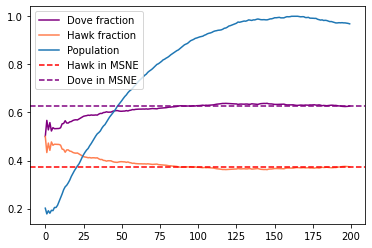

In [116]:
plt.clf()
plt.plot(npdovePer, color = "purple", label = "Dove fraction")
plt.plot(nphawkPer, color = "coral", label = "Hawk fraction")
plt.plot(nppopulation, label = "Population")
MSNE = game().findMSNE()
plt.axhline(y=MSNE[0][0],color = 'red', linestyle='--', label = "Hawk in MSNE")
plt.axhline(y=MSNE[0][1],color = 'purple', linestyle='--', label = "Dove in MSNE")
plt.legend()



plt.show()

In [117]:
print(MSNE)

[array([0.375, 0.625]), array([0.375, 0.625])]


In [ ]:
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 500
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 10
MAX_FOOD_PER_ROUND = 70
MAX_FOOD_APPEARANCE = 2000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 35
ENERGY_REQUIRED_FOR_LIVING = 10